# Libraries

In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, f1_score, recall_score

# Loading the processed Data

In [ ]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')['Class']
y_test = pd.read_csv('y_test.csv')['Class']

In [ ]:
print(X_train.shape)
print(y_train.shape)

(227604, 30)
(227604,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(56902, 30)
(56902,)


# OverSampling/UnderSampling

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Create Sequential Data

In [ ]:
def create_sequences(X, y, seq_length=10):
    sequences = []
    labels = []
    # Group by time to simulate user transaction sequences
    for i in range(0, len(X) - seq_length, seq_length):
        seq = X.iloc[i:i + seq_length].values
        label = y.iloc[i + seq_length - 1]  # Label of the last transaction
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Computing Class weights

In [ ]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Training

In [ ]:
seq_length = 10
X_seq, y_seq = create_sequences(X_train, y_train, seq_length)
X_seq_smote, y_seq_smote = create_sequences(X_train_smote, y_train_smote, seq_length)
X_seq_under, y_seq_under = create_sequences(X_train_under, y_train_under, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

In [ ]:
datasets = [
    ('original', X_seq, y_seq, class_weight_dict),
    ('smote', X_seq_smote, y_seq_smote, None),  # No class weights for SMOTE as it's balanced
    ('undersampled', X_seq_under, y_seq_under, None)  # No class weights for undersampled as it's balanced
]
batches = [32, 64, 128, 256]

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def create_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['precision', 'recall', 'accuracy'])
    return model

In [148]:
for dataset_name, X_data, y_data, class_weights in datasets:
    for batch in batches:
        print(f'\nTraining recurrent neural network with dataset: {dataset_name}, batch size: {batch}')
        model = create_model((X_data.shape[1], X_data.shape[2]))
        history = model.fit(
            X_data, y_data,
            epochs=50,
            batch_size=batch,
            validation_split=0.2,
            class_weight=class_weights,
            callbacks=[early_stopping],
            verbose=1
        )


        model_name = f'model_{dataset_name}_batch{batch}.h5'
        model.save(model_name)
        print(f"Model saved as {model_name}")


Training recurrent neural network with dataset: original, batch size: 32
Epoch 1/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.8560 - loss: 0.6654 - precision: 0.0052 - recall: 0.4902 - val_accuracy: 0.9550 - val_loss: 0.4374 - val_precision: 0.0286 - val_recall: 0.8571
Epoch 2/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9678 - loss: 0.2205 - precision: 0.0358 - recall: 0.8214 - val_accuracy: 0.9941 - val_loss: 0.0568 - val_precision: 0.1875 - val_recall: 0.8571
Epoch 3/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9831 - loss: 0.0766 - precision: 0.0801 - recall: 0.9485 - val_accuracy: 0.9750 - val_loss: 0.0589 - val_precision: 0.0504 - val_recall: 0.8571
Epoch 4/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9890 - loss: 0.0242 - precision: 0.0935 - recall: 0.9754 - val_accuracy: 0.9952 - val_loss: 0.0212 - val_precision: 0.2222 - val_recall: 0.8571
Epoch 5/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9961 - loss

Model saved as model_original_batch32.h5

Training recurrent neural network with dataset: original, batch size: 64
Epoch 1/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9226 - loss: 0.5746 - precision: 0.0035 - recall: 0.1863 - val_accuracy: 0.7669 - val_loss: 0.5625 - val_precision: 0.0056 - val_recall: 0.8571
Epoch 2/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8922 - loss: 0.3070 - precision: 0.0160 - recall: 0.8891 - val_accuracy: 0.9923 - val_loss: 0.0376 - val_precision: 0.1500 - val_recall: 0.8571
Epoch 3/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9768 - loss: 0.1378 - precision: 0.0582 - recall: 0.8755 - val_accuracy: 0.9960 - val_loss: 0.0203 - val_precision: 0.2609 - val_recall: 0.8571
Epoch 4/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9754 - loss: 0.0790 - precision: 0.1052 - recall: 0.9337 - val_accuracy: 0.9914 - val_loss: 0.0309 - val_precision: 0.1364 - val_recall: 0.8571
Epoch 5/50
285/285 ━━━━━━━━━━━━━━━━━━━━

Model saved as model_original_batch64.h5

Training recurrent neural network with dataset: original, batch size: 128
Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9463 - loss: 0.5853 - precision: 0.0079 - recall: 0.1583 - val_accuracy: 0.9903 - val_loss: 0.4149 - val_precision: 0.1064 - val_recall: 0.7143
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9883 - loss: 0.3907 - precision: 0.0751 - recall: 0.6282 - val_accuracy: 0.9807 - val_loss: 0.1831 - val_precision: 0.0645 - val_recall: 0.8571
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9769 - loss: 0.1350 - precision: 0.0543 - recall: 0.9359 - val_accuracy: 0.9855 - val_loss: 0.0646 - val_precision: 0.0845 - val_recall: 0.8571
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9900 - loss: 0.0393 - precision: 0.1266 - recall: 0.9931 - val_accuracy: 0.9947 - val_loss: 0.0210 - val_precision: 0.2069 - val_recall: 0.8571
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━

Model saved as model_original_batch128.h5

Training recurrent neural network with dataset: original, batch size: 256
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.6730 - loss: 0.6443 - precision: 0.0035 - recall: 0.6406 - val_accuracy: 0.9466 - val_loss: 0.5234 - val_precision: 0.0203 - val_recall: 0.7143
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9587 - loss: 0.4403 - precision: 0.0241 - recall: 0.6907 - val_accuracy: 0.9688 - val_loss: 0.2432 - val_precision: 0.0408 - val_recall: 0.8571
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9787 - loss: 0.2157 - precision: 0.0671 - recall: 0.9567 - val_accuracy: 0.9772 - val_loss: 0.1378 - val_precision: 0.0550 - val_recall: 0.8571
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9836 - loss: 0.0806 - precision: 0.0842 - recall: 0.9452 - val_accuracy: 0.9943 - val_loss: 0.0326 - val_precision: 0.1935 - val_recall: 0.8571
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/s

Model saved as model_original_batch256.h5

Training recurrent neural network with dataset: smote, batch size: 32
Epoch 1/50
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.9858 - loss: 0.0707 - precision: 0.9760 - recall: 0.9893 - val_accuracy: 1.0000 - val_loss: 3.1935e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9991 - loss: 0.0028 - precision: 1.0000 - recall: 0.9975 - val_accuracy: 1.0000 - val_loss: 7.9421e-06 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/50
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.9995 - loss: 0.0015 - precision: 1.0000 - recall: 0.9987 - val_accuracy: 1.0000 - val_loss: 1.6049e-06 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/50
1136/1136 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9997 - loss: 0.0012 - precision: 0.9997 - recall: 0.9995 - val_accuracy: 1.0000 - val_loss: 1.6408e-06 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/50
1136

Model saved as model_smote_batch32.h5

Training recurrent neural network with dataset: smote, batch size: 64
Epoch 1/50
568/568 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.9622 - loss: 0.1108 - precision: 0.9260 - recall: 0.9976 - val_accuracy: 1.0000 - val_loss: 7.6081e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
568/568 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9991 - loss: 0.0039 - precision: 0.9999 - recall: 0.9976 - val_accuracy: 0.9998 - val_loss: 9.4486e-04 - val_precision: 1.0000 - val_recall: 0.9998
Epoch 3/50
568/568 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9997 - loss: 0.0018 - precision: 0.9999 - recall: 0.9993 - val_accuracy: 1.0000 - val_loss: 5.7058e-06 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/50
568/568 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9997 - loss: 0.0011 - precision: 0.9997 - recall: 0.9994 - val_accuracy: 1.0000 - val_loss: 5.6265e-06 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/50
568/568 ━━━━━━━━━

Model saved as model_smote_batch64.h5

Training recurrent neural network with dataset: smote, batch size: 128
Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.9828 - loss: 0.1439 - precision: 0.9672 - recall: 0.9908 - val_accuracy: 1.0000 - val_loss: 6.1427e-04 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9993 - loss: 0.0045 - precision: 1.0000 - recall: 0.9981 - val_accuracy: 0.9992 - val_loss: 0.0022 - val_precision: 1.0000 - val_recall: 0.9992
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9990 - loss: 0.0026 - precision: 1.0000 - recall: 0.9975 - val_accuracy: 1.0000 - val_loss: 5.1247e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.9995 - loss: 0.0021 - precision: 0.9995 - recall: 0.9991 - val_accuracy: 1.0000 - val_loss: 2.1473e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/50
284/284 ━━━━━━━━━━━━

Model saved as model_smote_batch128.h5

Training recurrent neural network with dataset: smote, batch size: 256
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9041 - loss: 0.2814 - precision: 0.8273 - recall: 0.9959 - val_accuracy: 1.0000 - val_loss: 5.8938e-04 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9993 - loss: 0.0063 - precision: 1.0000 - recall: 0.9981 - val_accuracy: 1.0000 - val_loss: 1.6264e-04 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9989 - loss: 0.0083 - precision: 1.0000 - recall: 0.9970 - val_accuracy: 1.0000 - val_loss: 9.2604e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9992 - loss: 0.0056 - precision: 1.0000 - recall: 0.9979 - val_accuracy: 1.0000 - val_loss: 5.2266e-05 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/50
142/142 ━━━━━━━

Model saved as model_smote_batch256.h5

Training recurrent neural network with dataset: undersampled, batch size: 32
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 991ms/step - accuracy: 0.2316 - loss: 0.8165 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0625 - val_loss: 0.7765 - val_precision: 1.0000 - val_recall: 0.0625
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3790 - loss: 0.7354 - precision: 0.1159 - recall: 0.1111 - val_accuracy: 0.6250 - val_loss: 0.6814 - val_precision: 1.0000 - val_recall: 0.6250
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6844 - loss: 0.6773 - precision: 0.5575 - recall: 0.6843 - val_accuracy: 1.0000 - val_loss: 0.5914 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8738 - loss: 0.6321 - precision: 0.7996 - recall: 0.8889 - val_accuracy: 1.0000 - val_loss: 0.4972 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153m

Model saved as model_undersampled_batch32.h5

Training recurrent neural network with dataset: undersampled, batch size: 64
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.7460 - loss: 0.6728 - precision: 0.6667 - recall: 0.6667 - val_accuracy: 1.0000 - val_loss: 0.6053 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8889 - loss: 0.6535 - precision: 0.7931 - recall: 0.9583 - val_accuracy: 1.0000 - val_loss: 0.5619 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9365 - loss: 0.6319 - precision: 0.8571 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5199 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9206 - loss: 0.6143 - precision: 0.8276 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.4791 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/ste

Model saved as model_undersampled_batch64.h5

Training recurrent neural network with dataset: undersampled, batch size: 128
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8254 - loss: 0.6644 - precision: 0.7826 - recall: 0.7500 - val_accuracy: 1.0000 - val_loss: 0.6028 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step - accuracy: 0.9524 - loss: 0.6411 - precision: 0.8889 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5596 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9524 - loss: 0.6237 - precision: 0.8889 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5206 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9524 - loss: 0.6024 - precision: 0.8889 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.4824 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/st

Model saved as model_undersampled_batch128.h5

Training recurrent neural network with dataset: undersampled, batch size: 256
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.6508 - loss: 0.6841 - precision: 0.5385 - recall: 0.5833 - val_accuracy: 1.0000 - val_loss: 0.5831 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8730 - loss: 0.6384 - precision: 0.7667 - recall: 0.9583 - val_accuracy: 1.0000 - val_loss: 0.5428 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8730 - loss: 0.6300 - precision: 0.7500 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.5105 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9206 - loss: 0.5994 - precision: 0.8276 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.4810 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/s

Model saved as model_undersampled_batch256.h5


# Evaluation

In [153]:
results = []
# Loop through datasets and batch sizes to load training and predict
for dataset_name,_,_,_ in datasets:
    for batch in batches:
        # Load the saved model
        model_name = f'model_{dataset_name}_batch{batch}.h5'
        model = load_model(model_name)
        # Predict on test set
        thresholds = [0.3, 0.4, 0.5]
        for threshold in thresholds:
             y_pred = (model.predict(X_test_seq) > threshold).astype(int).flatten()
             # Compute metrics for fraud class (Class 1)
             precision = precision_score(y_test_seq, y_pred, pos_label=1)
             f1 = f1_score(y_test_seq, y_pred, pos_label=1)
             recall = recall_score(y_test_seq, y_pred, pos_label=1)
             results.append({
                'dataset': dataset_name,
                'batch_size': batch,
                'precision': precision,
                'f1_score': f1,
                'threshold': threshold,
                'recall': recall
            })
             print(f"\nMetrics for dataset: {dataset_name}, batch size: {batch}, threshold: {threshold}")
             print(f"Precision: {precision:.4f}")
             print(f"Recall: {recall:.4f}")
             print(f"F1-Score: {f1:.4f}")


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Metrics for dataset: original, batch size: 32, threshold: 0.3
Precision: 1.0000
Recall: 0.8182
F1-Score: 0.9000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: original, batch size: 32, threshold: 0.4
Precision: 1.0000
Recall: 0.8182
F1-Score: 0.9000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step



Metrics for dataset: original, batch size: 32, threshold: 0.5
Precision: 1.0000
Recall: 0.8182
F1-Score: 0.9000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Metrics for dataset: original, batch size: 64, threshold: 0.3
Precision: 0.8182
Recall: 0.8182
F1-Score: 0.8182
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: original, batch size: 64, threshold: 0.4
Precision: 0.9000
Recall: 0.8182
F1-Score: 0.8571
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Metrics for dataset: original, batch size: 64, threshold: 0.5
Precision: 0.9000
Recall: 0.8182
F1-Score: 0.8571


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Metrics for dataset: original, batch size: 128, threshold: 0.3
Precision: 1.0000
Recall: 0.7273
F1-Score: 0.8421
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: original, batch size: 128, threshold: 0.4
Precision: 1.0000
Recall: 0.7273
F1-Score: 0.8421
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: original, batch size: 128, threshold: 0.5
Precision: 1.0000
Recall: 0.7273
F1-Score: 0.8421


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Metrics for dataset: original, batch size: 256, threshold: 0.3
Precision: 0.8182
Recall: 0.8182
F1-Score: 0.8182
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: original, batch size: 256, threshold: 0.4
Precision: 0.9000
Recall: 0.8182
F1-Score: 0.8571
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: original, batch size: 256, threshold: 0.5
Precision: 1.0000
Recall: 0.8182
F1-Score: 0.9000


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Metrics for dataset: smote, batch size: 32, threshold: 0.3
Precision: 0.9000
Recall: 0.8182
F1-Score: 0.8571
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Metrics for dataset: smote, batch size: 32, threshold: 0.4
Precision: 0.9000
Recall: 0.8182
F1-Score: 0.8571
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step



Metrics for dataset: smote, batch size: 32, threshold: 0.5
Precision: 0.9000
Recall: 0.8182
F1-Score: 0.8571
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

Metrics for dataset: smote, batch size: 64, threshold: 0.3
Precision: 1.0000
Recall: 0.8182
F1-Score: 0.9000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Metrics for dataset: smote, batch size: 64, threshold: 0.4
Precision: 1.0000
Recall: 0.8182
F1-Score: 0.9000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step



Metrics for dataset: smote, batch size: 64, threshold: 0.5
Precision: 1.0000
Recall: 0.8182
F1-Score: 0.9000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Metrics for dataset: smote, batch size: 128, threshold: 0.3
Precision: 0.9000
Recall: 0.8182
F1-Score: 0.8571
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: smote, batch size: 128, threshold: 0.4
Precision: 0.9000
Recall: 0.8182
F1-Score: 0.8571
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: smote, batch size: 128, threshold: 0.5
Precision: 0.9000
Recall: 0.8182
F1-Score: 0.8571


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Metrics for dataset: smote, batch size: 256, threshold: 0.3
Precision: 0.9000
Recall: 0.8182
F1-Score: 0.8571
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: smote, batch size: 256, threshold: 0.4
Precision: 0.9000
Recall: 0.8182
F1-Score: 0.8571
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step



Metrics for dataset: smote, batch size: 256, threshold: 0.5
Precision: 0.9000
Recall: 0.8182
F1-Score: 0.8571
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Metrics for dataset: undersampled, batch size: 32, threshold: 0.3
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: undersampled, batch size: 32, threshold: 0.4
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step



Metrics for dataset: undersampled, batch size: 32, threshold: 0.5
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step

Metrics for dataset: undersampled, batch size: 64, threshold: 0.3
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: undersampled, batch size: 64, threshold: 0.4
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: undersampled, batch size: 64, threshold: 0.5
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Metrics for dataset: undersampled, batch size: 128, threshold: 0.3
Precision: 0.0250
Recall: 0.0909
F1-Score: 0.0392
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Metrics for dataset: undersampled, batch size: 128, threshold: 0.4
Precision: 0.0263
Recall: 0.0909
F1-Score: 0.0408
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step



Metrics for dataset: undersampled, batch size: 128, threshold: 0.5
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Metrics for dataset: undersampled, batch size: 256, threshold: 0.3
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Metrics for dataset: undersampled, batch size: 256, threshold: 0.4
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Metrics for dataset: undersampled, batch size: 256, threshold: 0.5
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000



Results Table:
         dataset  batch_size  precision  f1_score  threshold    recall
0       original          32   1.000000  0.900000        0.3  0.818182
1       original          32   1.000000  0.900000        0.4  0.818182
2       original          32   1.000000  0.900000        0.5  0.818182
3       original          64   0.818182  0.818182        0.3  0.818182
4       original          64   0.900000  0.857143        0.4  0.818182
5       original          64   0.900000  0.857143        0.5  0.818182
6       original         128   1.000000  0.842105        0.3  0.727273
7       original         128   1.000000  0.842105        0.4  0.727273
8       original         128   1.000000  0.842105        0.5  0.727273
9       original         256   0.818182  0.818182        0.3  0.818182
10      original         256   0.900000  0.857143        0.4  0.818182
11      original         256   1.000000  0.900000        0.5  0.818182
12         smote          32   0.900000  0.857143        0.3 

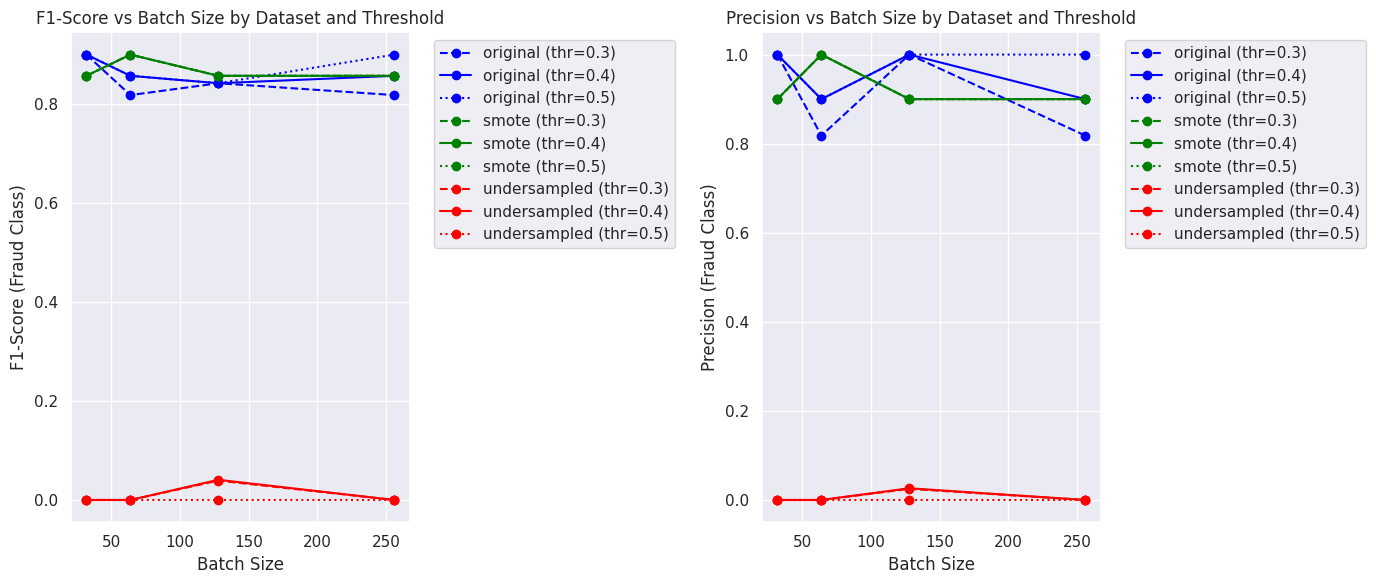


Plot saved as 'model_comparison_plot.png'


In [154]:
print("\nResults Table:")
results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(14, 6))

line_styles = {0.3: '--', 0.4: '-', 0.5: ':'}
colors = {'original': 'blue', 'smote': 'green', 'undersampled': 'red'}

plt.subplot(1, 2, 1)
for dataset_name in results_df['dataset'].unique():
    for threshold in thresholds:
        subset = results_df[(results_df['dataset'] == dataset_name) & (results_df['threshold'] == threshold)]
        if not subset.empty:
            plt.plot(
                subset['batch_size'],
                subset['f1_score'],
                marker='o',
                linestyle=line_styles[threshold],
                color=colors[dataset_name],
                label=f'{dataset_name} (thr={threshold})'
            )
plt.xlabel('Batch Size')
plt.ylabel('F1-Score (Fraud Class)')
plt.title('F1-Score vs Batch Size by Dataset and Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.subplot(1, 2, 2)
for dataset_name in results_df['dataset'].unique():
    for threshold in thresholds:
        subset = results_df[(results_df['dataset'] == dataset_name) & (results_df['threshold'] == threshold)]
        if not subset.empty:
            plt.plot(
                subset['batch_size'],
                subset['precision'],
                marker='o',
                linestyle=line_styles[threshold],
                color=colors[dataset_name],
                label=f'{dataset_name} (thr={threshold})'
            )
plt.xlabel('Batch Size')
plt.ylabel('Precision (Fraud Class)')
plt.title('Precision vs Batch Size by Dataset and Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.savefig('model_comparison.png')
plt.close()

print("\nPlot saved as 'model_comparison.png'")